In [ ]:
# !rm -rf "/content/acne_dataset"
# !rm -rf "/content/acne_detection"
# !rm -rf "/content/sample_data"
# !rm -rf "/content/yolo11n.pt"
# !rm -rf "/content/yolov8m.pt"
# !rm -rf "/content/runs"

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, tensorflow as tf
print("TF:", tf.__version__)
print("physical devices:", tf.config.list_physical_devices())
print("GPUs:", tf.config.list_physical_devices('GPU'))

import sys, os
print("Python exec:", sys.executable)

TF: 2.19.0
physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Python exec: /usr/bin/python3


In [ ]:
import sys, os
print("Python exec:", sys.executable)
import subprocess

# versi TF
try:
    import tensorflow as tf
    print("TF version:", tf.__version__)
    print("TF built with CUDA:", tf.test.is_built_with_cuda())
    print("Physical GPUs:", tf.config.list_physical_devices('GPU'))
except Exception as e:
    print("Import TF error:", repr(e))

# info pip & package location
print("\nPip show tensorflow:")
!"{sys.executable}" -m pip show tensorflow

# nvidia-smi
print("\nOutput nvidia-smi:")
!nvidia-smi

Python exec: /usr/bin/python3
TF version: 2.19.0
TF built with CUDA: True
Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Pip show tensorflow:
Name: tensorflow
Version: 2.19.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras

Output nvidia-smi:
Fri Dec 19 17:02:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|---

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, average_precision_score
from tabulate import tabulate
import seaborn as sns
import yaml
import shutil
from pathlib import Path
from PIL import Image, ImageEnhance
import albumentations as A

# Ultralytics YOLOv8
!pip install ultralytics
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors

# For Google Colab
from google.colab import drive
from IPython.display import display, Image as IPImage
from PIL import Image, ImageDraw, ImageFont

In [ ]:
#from google.colab import files
import io
from datetime import datetime

In [ ]:
class_mapping = {0: 'blackhead', 1: 'nodul', 2: 'papule', 3: 'pustule'} # ubah ini
class_id_to_index = {1:0, 3: 1, 4: 2, 5:3} # ubah ini

def enhance_image(image_path, save_path=None):
    img = cv2.imread(image_path)
    if img is None:
        return None

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    l = clahe.apply(l)

    lab = cv2.merge([l, a, b])
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    kernel = np.array([[0, -1, 0],
                       [-1,  5, -1],
                       [0, -1,  0]])

    enhanced = cv2.filter2D(enhanced, -1, kernel)

    gamma = 1.05
    inv_gamma = 1.0 / gamma
    table = np.array([
        ((i / 255.0) ** inv_gamma) * 255
        for i in np.arange(256)
    ]).astype("uint8")

    final = cv2.LUT(enhanced, table)

    if save_path:
        cv2.imwrite(save_path, final)

    return final

def enhance_dataset_images(src_images_dir, dst_images_dir, show_samples=False):
    os.makedirs(dst_images_dir, exist_ok=True)

    image_files = [f for f in os.listdir(src_images_dir) if f.endswith('.jpg')]

    print(f"Enhancing {len(image_files)} images...")

    if show_samples and len(image_files) > 0:
        sample_files = random.sample(image_files, min(3, len(image_files)))
        fig, axes = plt.subplots(len(sample_files), 2, figsize=(10, 5*len(sample_files)))
        if len(sample_files) == 1:
            axes = axes.reshape(1, -1)

        for idx, img_file in enumerate(sample_files):
            orig_path = os.path.join(src_images_dir, img_file)
            orig_img = cv2.imread(orig_path)
            orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

            enhanced_img = enhance_image(orig_path)
            enhanced_img = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB)

            axes[idx, 0].imshow(orig_img)
            axes[idx, 0].set_title(f'Original: {img_file}')
            axes[idx, 0].axis('off')

            axes[idx, 1].imshow(enhanced_img)
            axes[idx, 1].set_title('Enhanced')
            axes[idx, 1].axis('off')

        plt.tight_layout()
        plt.show()

    for img_file in tqdm(image_files):
        src_path = os.path.join(src_images_dir, img_file)
        dst_path = os.path.join(dst_images_dir, img_file)
        enhance_image(src_path, dst_path)

    print(f"Enhanced images saved to: {dst_images_dir}")

def create_augmentation_pipeline():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.03,
            scale_limit=0.05,
            rotate_limit=10,
            border_mode=0,
            p=0.4
        ),

        A.OneOf([
            A.RandomBrightnessContrast(
                brightness_limit=0.08,
                contrast_limit=0.08,
            ),
            A.CLAHE(clip_limit=2.0),
        ], p=0.4),

        A.GaussNoise(
            var_limit=(3, 10),
            p=0.15
        ),

        A.OneOf([
            A.MotionBlur(blur_limit=2),
            A.GaussianBlur(blur_limit=(1, 2)),
            A.MedianBlur(blur_limit=3),
        ], p=0.12),

        A.Sharpen(alpha=(0.05, 0.15), p=0.15),

        A.CoarseDropout(
            max_holes=2,
            max_height=12,
            max_width=12,
            min_holes=1,
            min_height=6,
            min_width=6,
            p=0.10
        ),

        A.Resize(640, 640)
    ], bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"]))

def copy_dataset_files_with_enhancement(src_images, src_labels, dst_images, dst_labels, enhance=True):
    if enhance:
        print("Enhancing images...")
        temp_enhanced = src_images + '_enhanced'
        enhance_dataset_images(src_images, temp_enhanced, show_samples=True)
        src_images = temp_enhanced

    for img in os.listdir(src_images):
        shutil.copy2(os.path.join(src_images, img), os.path.join(dst_images, img))

    convert_labels_for_ultralytics(src_labels, dst_labels)

    if enhance and os.path.exists(temp_enhanced):
        shutil.rmtree(temp_enhanced)

def prepare_dataset_structure(base_path='/content/acne_dataset'):
    for split in ['train', 'val', 'test']:
        os.makedirs(f"{base_path}/{split}/images", exist_ok=True)
        os.makedirs(f"{base_path}/{split}/labels", exist_ok=True)

    return base_path

def convert_labels_for_ultralytics(src_labels_dir, dst_labels_dir):
    label_files = os.listdir(src_labels_dir)

    for label_file in label_files:
        src_path = os.path.join(src_labels_dir, label_file)
        dst_path = os.path.join(dst_labels_dir, label_file)

        with open(src_path, 'r', encoding='utf-8-sig') as f:
            lines = f.readlines()

        new_lines = []
        for line in lines:
            if line.strip():
                clean_line = line.strip().replace('\ufeff', '')
                parts = clean_line.split()

                try:
                    class_id = int(parts[0])

                    if class_id in class_id_to_index:
                        parts[0] = str(class_id_to_index[class_id])
                        new_lines.append(' '.join(parts) + '\n')
                except (ValueError, IndexError) as e:
                    print(f"Skipping invalid line in {label_file}: {line.strip()}")
                    continue

        with open(dst_path, 'w') as f:
            f.writelines(new_lines)

def copy_dataset_files(src_images, src_labels, dst_images, dst_labels):
    for img in os.listdir(src_images):
        shutil.copy2(os.path.join(src_images, img), os.path.join(dst_images, img))

    convert_labels_for_ultralytics(src_labels, dst_labels)

In [ ]:
def count_annotations(labels_dir):
    class_counts = {0: 0, 1: 0, 2: 0, 3:0} # ubah ini

    for label_file in os.listdir(labels_dir):
        with open(os.path.join(labels_dir, label_file), 'r', encoding='utf-8-sig') as f:
            lines = f.readlines()
            for line in lines:
                if line.strip():
                    try:
                        clean_line = line.strip().replace('\ufeff', '')
                        class_id = int(clean_line.split()[0])
                        if class_id in class_counts:
                            class_counts[class_id] += 1
                    except (ValueError, IndexError):
                        continue

    return class_counts

In [ ]:
def balance_dataset_by_annotations(images_dir, labels_dir, output_images_dir, output_labels_dir, dataset_name="Dataset"):
    print(f"\nBalancing {dataset_name}:")
    all_annotations = {0: [], 1: [], 2: [], 3:[]} # ubah ini

    for label_file in os.listdir(labels_dir):
        label_path = os.path.join(labels_dir, label_file)
        image_name = label_file.replace('.txt', '.jpg')

        with open(label_path, 'r', encoding='utf-8-sig') as f:
            lines = f.readlines()

        for line_idx, line in enumerate(lines):
            if line.strip():
                try:
                    clean_line = line.strip().replace('\ufeff', '')
                    parts = clean_line.split()
                    class_id = int(parts[0])

                    if class_id in all_annotations:
                        all_annotations[class_id].append({
                            'image_name': image_name,
                            'label_file': label_file,
                            'line': line.strip(),
                            'line_idx': line_idx
                        })
                except (ValueError, IndexError):
                    continue

    original_counts = {k: len(v) for k, v in all_annotations.items()}
    print(f"Original: Black head={original_counts[0]}, Nodule={original_counts[1]}, Papule={original_counts[2]}, Pustule={original_counts[3]}") # ubah ini

    min_samples = min(len(all_annotations[k]) for k in [0, 1, 2, 3]) # ubah ini
    print(f"Balancing to smallest class: {min_samples} samples per class")

    sampled_annotations = {0: [], 1: [], 2: [], 3:[]} # ubah ini
    for class_id in [0, 1, 2, 3]: # ubah ini
        sampled = random.sample(all_annotations[class_id], min_samples)
        sampled_annotations[class_id] = sampled
        print(f"  {class_mapping[class_id]}: {len(sampled)} samples selected")

    image_annotations = {}
    for class_id, annotations in sampled_annotations.items():
        for ann in annotations:
            img_name = ann['image_name']
            if img_name not in image_annotations:
                image_annotations[img_name] = []
            image_annotations[img_name].append(ann['line'])

    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)

    for img_name, annotations in image_annotations.items():
        src_img = os.path.join(images_dir, img_name)
        dst_img = os.path.join(output_images_dir, img_name)
        if os.path.exists(src_img):
            shutil.copy2(src_img, dst_img)

        label_name = img_name.replace('.jpg', '.txt')
        label_path = os.path.join(output_labels_dir, label_name)

        with open(label_path, 'w') as f:
            for ann_line in annotations:
                f.write(ann_line + '\n')

    total_samples = sum(len(sampled_annotations[k]) for k in [0, 1, 2, 3]) # ubah ini
    print(f"Final {dataset_name}: {total_samples} total samples")

    return sampled_annotations

base_path = prepare_dataset_structure()

In [ ]:
print("Preparing training data...")
copy_dataset_files(
    '/content/drive/MyDrive/Handover/Data/Clean/train/images',
    '/content/drive/MyDrive/Handover/Data/Clean/train/labels',
    f'{base_path}/train/images',
    f'{base_path}/train/labels'
)

print("Preparing validation data...")
copy_dataset_files(
    '/content/drive/MyDrive/Handover/Data/Clean/valid/images',
    '/content/drive/MyDrive/Handover/Data/Clean/valid/labels',
    f'{base_path}/val/images',
    f'{base_path}/val/labels'
)

print("Preparing test data...")
copy_dataset_files(
    '/content/drive/MyDrive/Handover/Data/Clean/test/images',
    '/content/drive/MyDrive/Handover/Data/Clean/test/labels',
    f'{base_path}/test/images',
    f'{base_path}/test/labels'
)

Preparing training data...
Preparing validation data...
Preparing test data...


In [ ]:
def plot_class_distribution(labels_dir, title):
    counts = count_annotations(labels_dir)

    plt.figure(figsize=(10, 6))
    classes = [class_mapping[i] for i in class_mapping.keys()]
    values = [counts[i] for i in class_mapping.keys()]


    bars = plt.bar(classes, values, alpha=0.75, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for bar, count in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                str(count), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

In [ ]:
print(class_mapping)

{0: 'blackhead', 1: 'nodul', 2: 'papule', 3: 'pustule'}


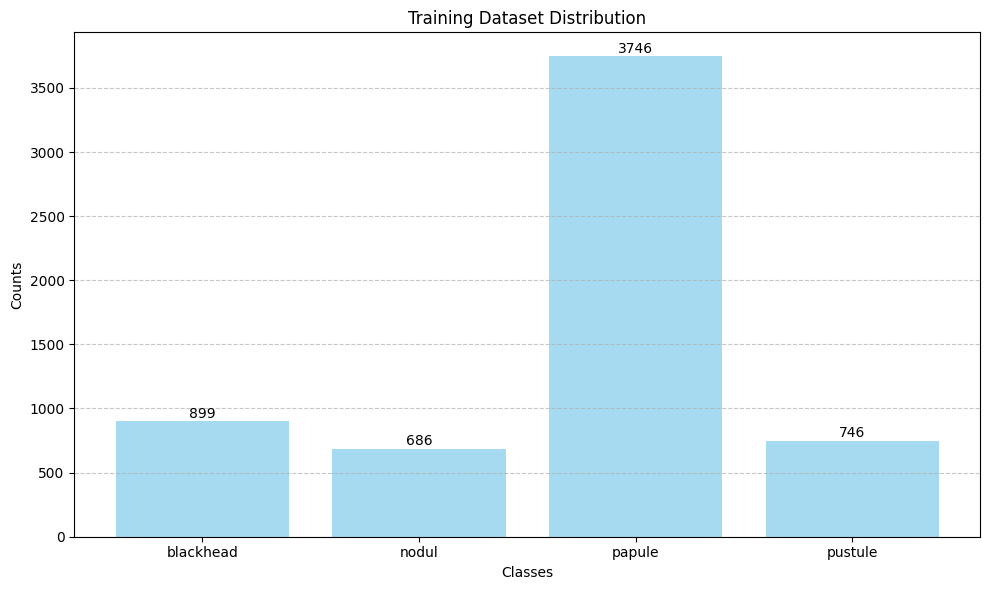

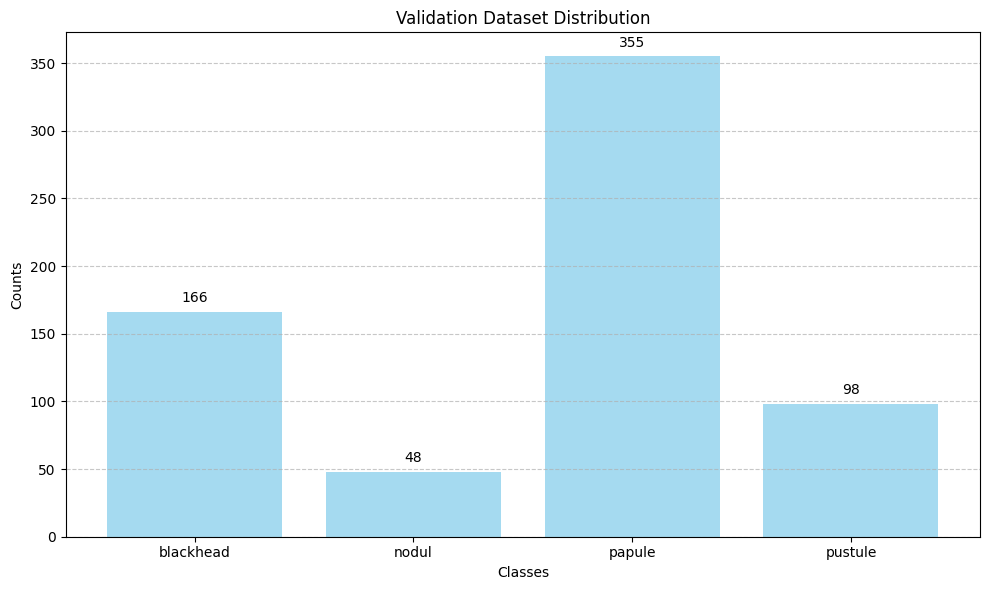

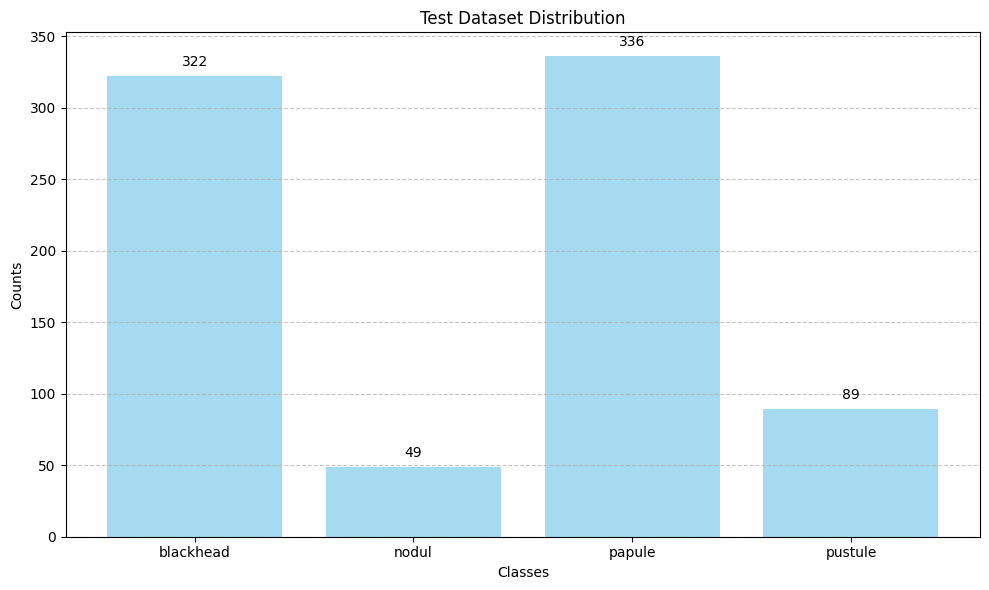

In [ ]:
plot_class_distribution(f'{base_path}/train/labels', 'Training Dataset Distribution')
plot_class_distribution(f'{base_path}/val/labels', 'Validation Dataset Distribution')
plot_class_distribution(f'{base_path}/test/labels', 'Test Dataset Distribution')

In [ ]:
def visualize_dataset_samples(images_dir, labels_dir, num_samples=6, title="Dataset Samples"):
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    sample_files = random.sample(image_files, min(num_samples, len(image_files)))

    cols = 3
    rows = (num_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    axes = axes.flatten() if num_samples > 1 else [axes]

    colors = {
        0: (255, 0, 0),
        1: (0, 255, 0),
        2: (0, 0, 255),
        3: (0,255,255)
        #4: (255,0,255), # ubah ini
    }

    for idx, img_file in enumerate(sample_files):
        img_path = os.path.join(images_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        label_file = img_file.replace('.jpg', '.txt')
        label_path = os.path.join(labels_dir, label_file)

        if os.path.exists(label_path):
            with open(label_path, 'r', encoding='utf-8-sig') as f:
                lines = f.readlines()

            for line in lines:
                if line.strip():
                    try:
                        parts = line.strip().replace('\ufeff', '').split()
                        class_id = int(parts[0])
                        x_center = float(parts[1])
                        y_center = float(parts[2])
                        bbox_width = float(parts[3])
                        bbox_height = float(parts[4])

                        x1 = int((x_center - bbox_width/2) * w)
                        y1 = int((y_center - bbox_height/2) * h)
                        x2 = int((x_center + bbox_width/2) * w)
                        y2 = int((y_center + bbox_height/2) * h)

                        color = colors.get(class_id, (255, 255, 255))
                        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

                        label_text = class_mapping.get(class_id, f"Class {class_id}")
                        cv2.putText(img, label_text, (x1, y1-5),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                    except:
                        continue

        axes[idx].imshow(img)
        axes[idx].set_title(f'{img_file}')
        axes[idx].axis('off')

    for idx in range(num_samples, len(axes)):
        axes[idx].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


Training Dataset Samples:


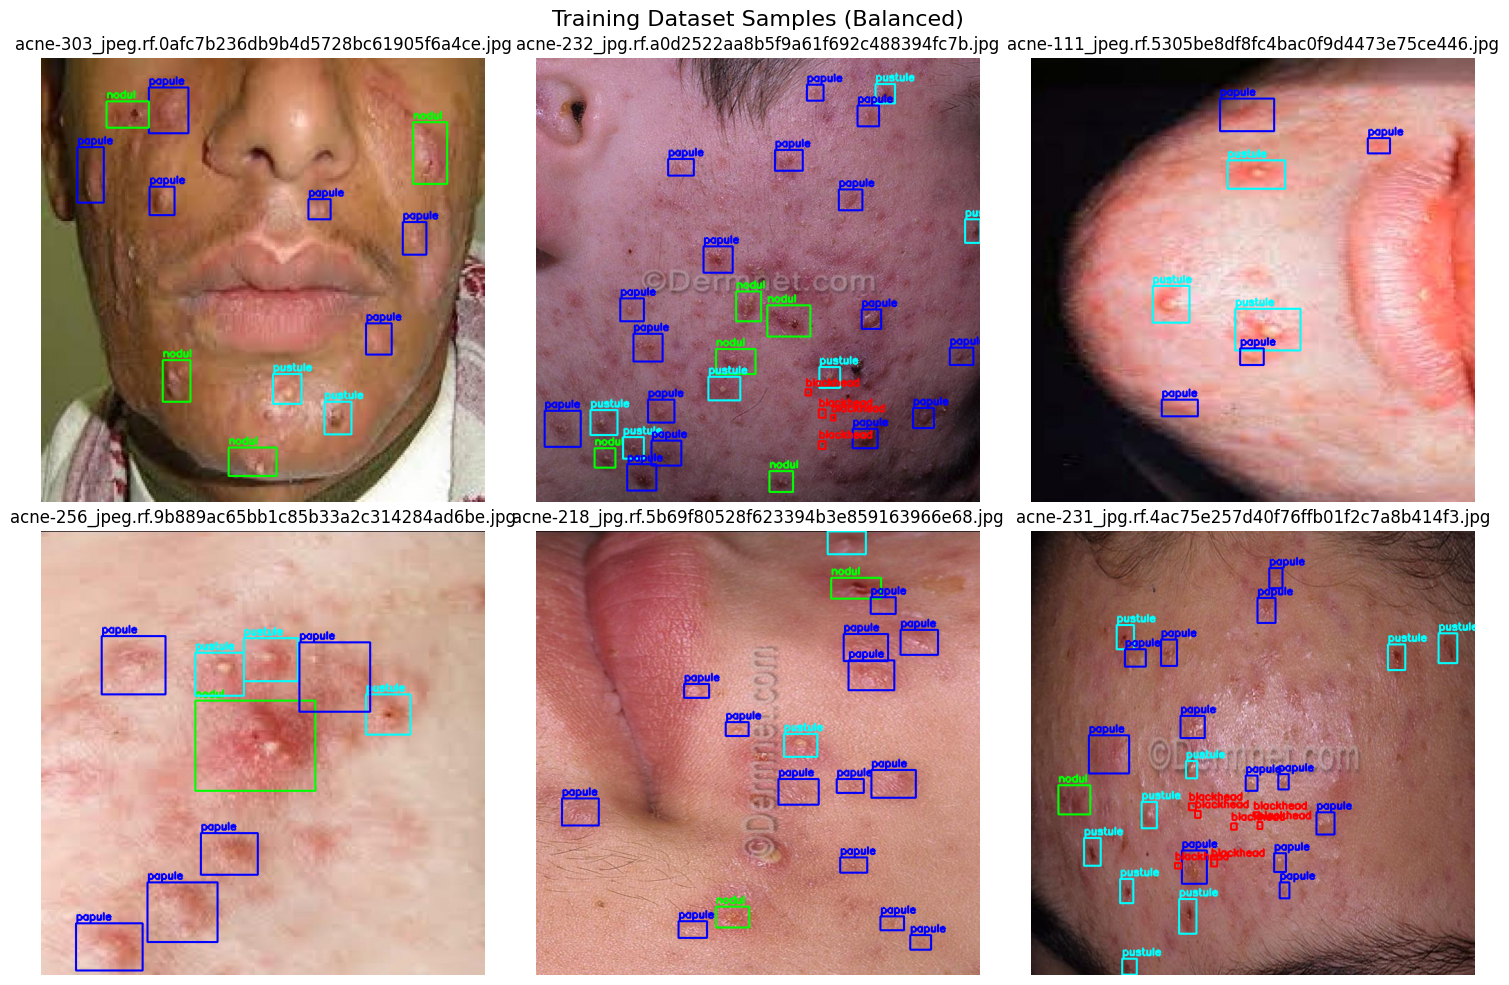


Validation Dataset Samples:


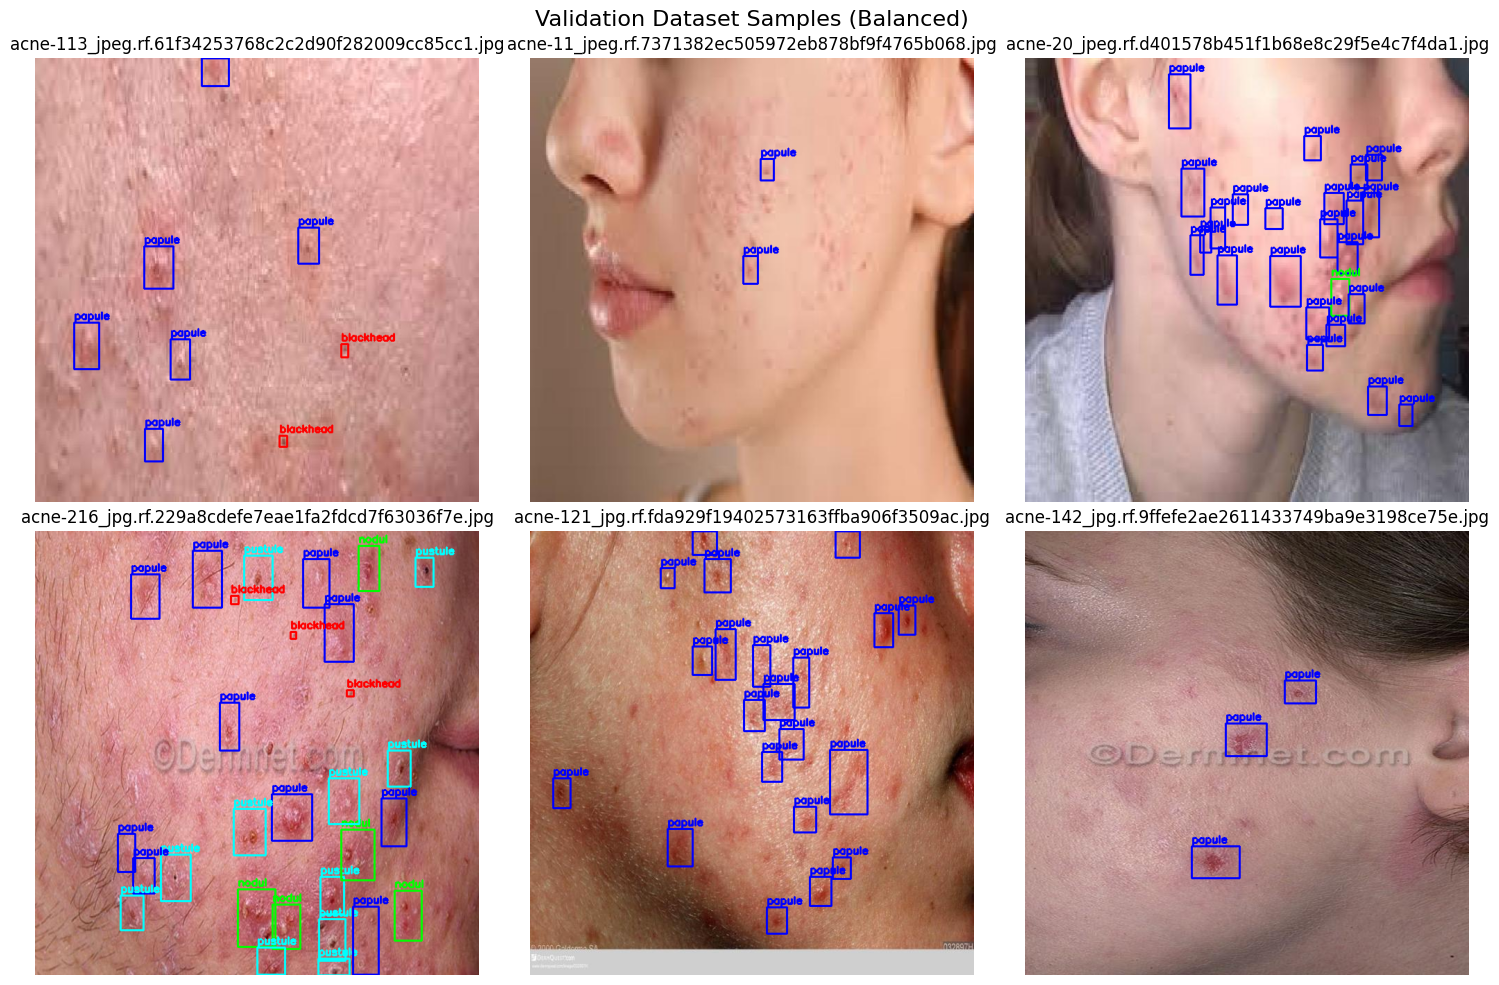


Test Dataset Samples:


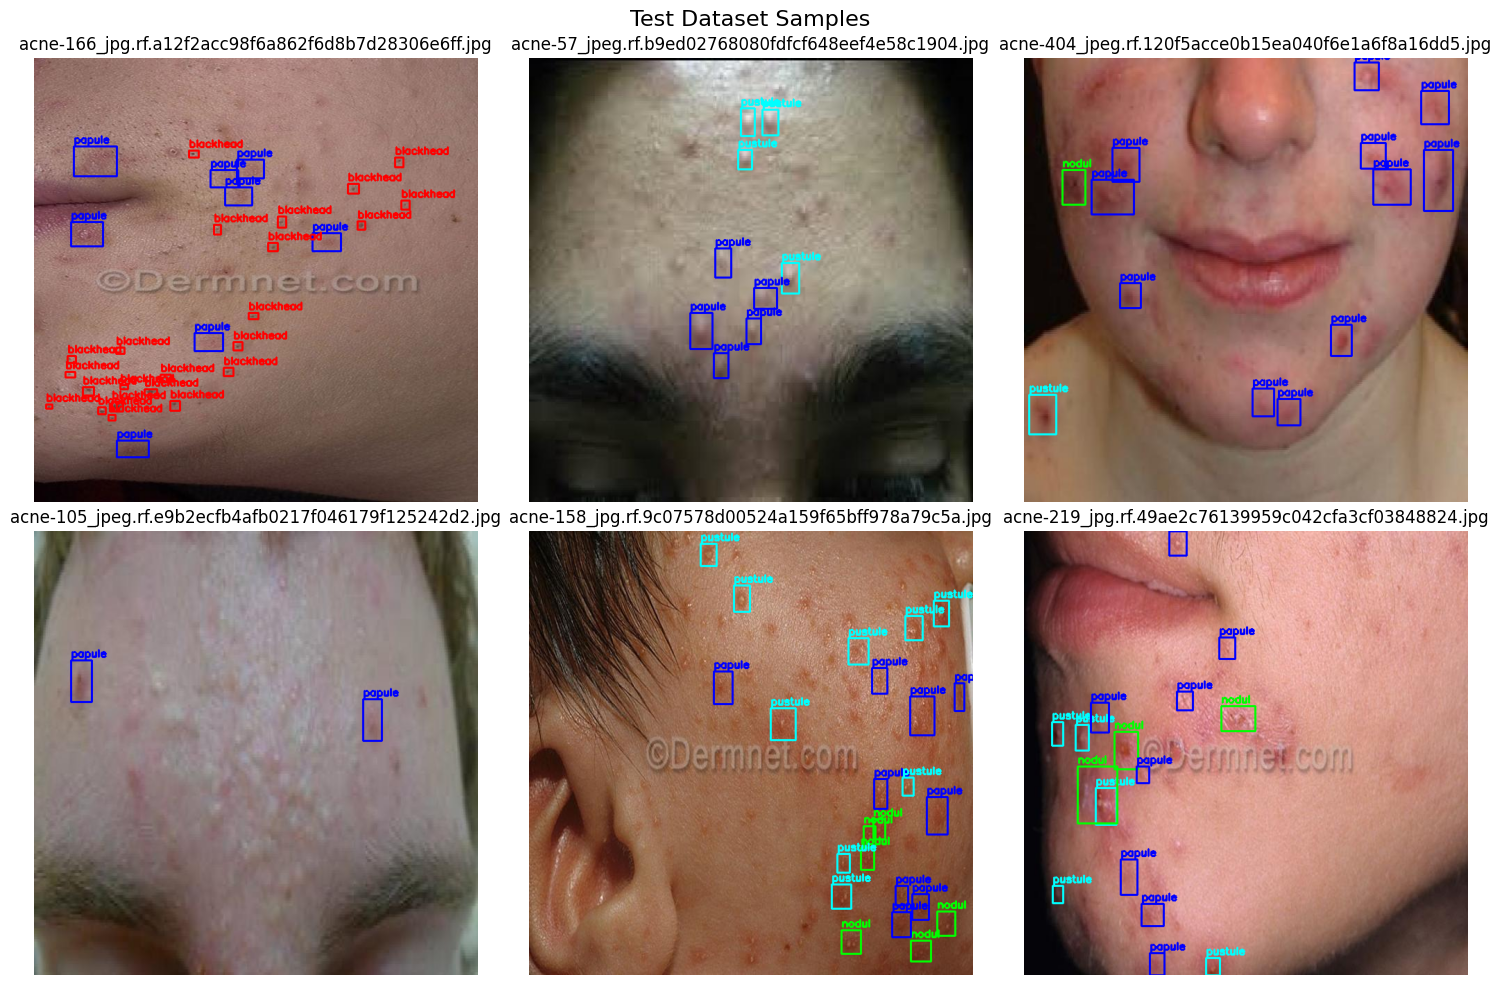

In [ ]:
print("\nTraining Dataset Samples:")
visualize_dataset_samples(
    f'{base_path}/train/images',
    f'{base_path}/train/labels',
    num_samples=6,
    title="Training Dataset Samples (Balanced)"
)

print("\nValidation Dataset Samples:")
visualize_dataset_samples(
    f'{base_path}/val/images',
    f'{base_path}/val/labels',
    num_samples=6,
    title="Validation Dataset Samples (Balanced)"
)

print("\nTest Dataset Samples:")
visualize_dataset_samples(
    f'{base_path}/test/images',
    f'{base_path}/test/labels',
    num_samples=6,
    title="Test Dataset Samples"
)

In [ ]:
print("\nBalancing datasets...")
balance_dataset_by_annotations(
    f'{base_path}/train/images',
    f'{base_path}/train/labels',
    f'{base_path}/train_balanced/images',
    f'{base_path}/train_balanced/labels',
    dataset_name="Training Set"
)

balance_dataset_by_annotations(
    f'{base_path}/val/images',
    f'{base_path}/val/labels',
    f'{base_path}/val_balanced/images',
    f'{base_path}/val_balanced/labels',
    dataset_name="Validation Set"
)


Balancing datasets...

Balancing Training Set:
Original: Black head=899, Nodule=686, Papule=3746, Pustule=746
Balancing to smallest class: 686 samples per class
  blackhead: 686 samples selected
  nodul: 686 samples selected
  papule: 686 samples selected
  pustule: 686 samples selected
Final Training Set: 2744 total samples

Balancing Validation Set:
Original: Black head=166, Nodule=48, Papule=355, Pustule=98
Balancing to smallest class: 48 samples per class
  blackhead: 48 samples selected
  nodul: 48 samples selected
  papule: 48 samples selected
  pustule: 48 samples selected
Final Validation Set: 192 total samples


{0: [{'image_name': 'acne-224_jpg.rf.21be34e10c2c539505d35f293f36f36d.jpg',
   'label_file': 'acne-224_jpg.rf.21be34e10c2c539505d35f293f36f36d.txt',
   'line': '0 0.451562 0.695312 0.015625 0.012500',
   'line_idx': 24},
  {'image_name': 'acne-223_jpg.rf.1b603f941d5d6b2ed05a4998dabd83d4.jpg',
   'label_file': 'acne-223_jpg.rf.1b603f941d5d6b2ed05a4998dabd83d4.txt',
   'line': '0 0.525781 0.612500 0.017188 0.012500',
   'line_idx': 41},
  {'image_name': 'acne-162_jpg.rf.3e7a961c691682bef628b7784a4dd8e7.jpg',
   'label_file': 'acne-162_jpg.rf.3e7a961c691682bef628b7784a4dd8e7.txt',
   'line': '0 0.380469 0.467187 0.014063 0.012500',
   'line_idx': 18},
  {'image_name': 'acne-134_jpg.rf.417c82e7063a6160461440b5758b9993.jpg',
   'label_file': 'acne-134_jpg.rf.417c82e7063a6160461440b5758b9993.txt',
   'line': '0 0.663281 0.953906 0.014063 0.020313',
   'line_idx': 26},
  {'image_name': 'acne-224_jpg.rf.21be34e10c2c539505d35f293f36f36d.jpg',
   'label_file': 'acne-224_jpg.rf.21be34e10c2c539505

In [ ]:
data_yaml = {
    'path': base_path,
    'train': 'train/images',
    'val': 'val/images',
    'test': 'test/images',
    'nc': 4, # ubah ini
    'names': ['blackhead', 'nodul', 'papule', 'pustule'] # ubah ini
}

yaml_path = f'{base_path}/data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f)

print(f"\nDataset configuration saved to: {yaml_path}")


Dataset configuration saved to: /content/acne_dataset/data.yaml


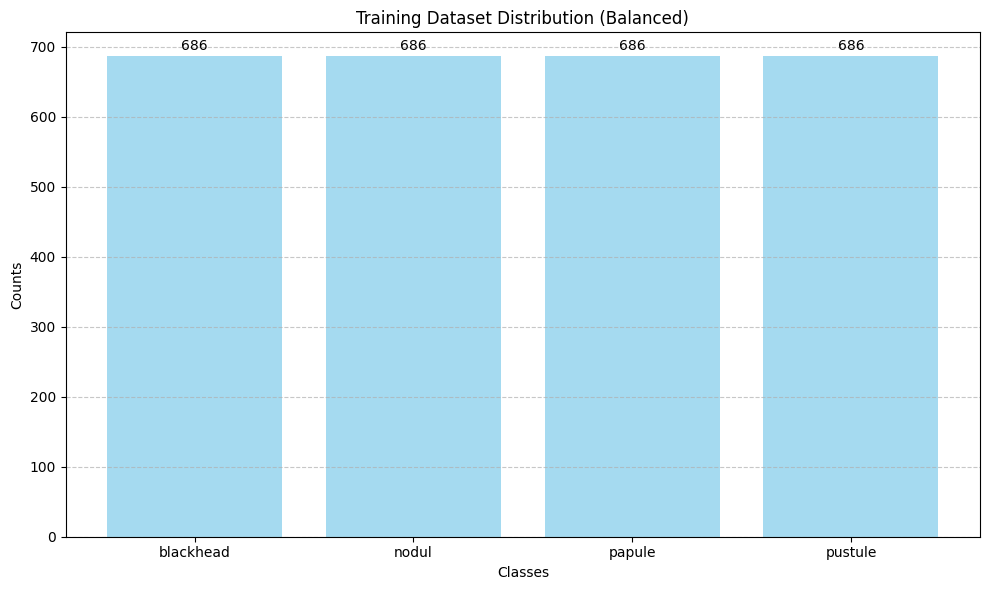

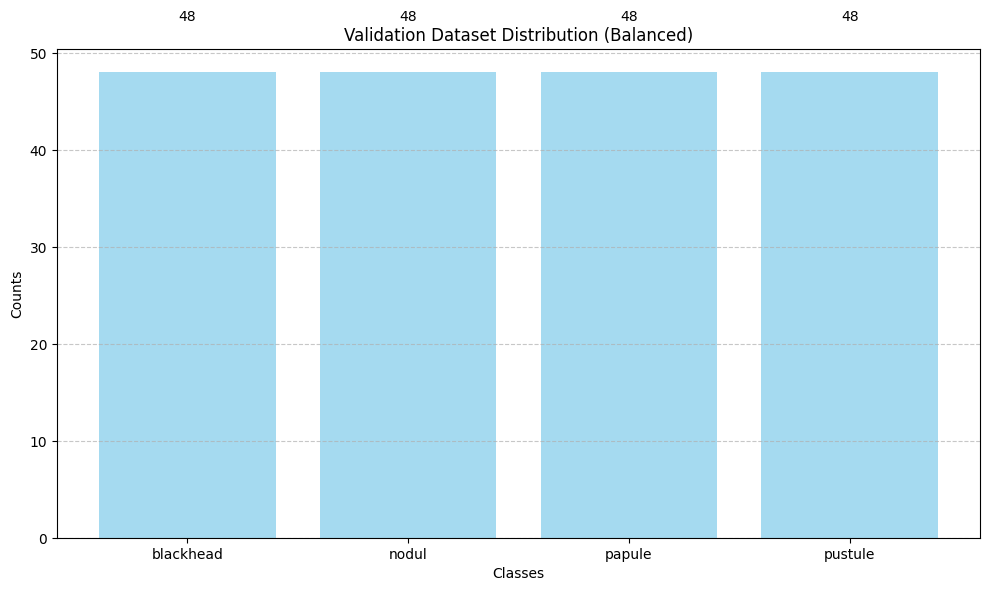

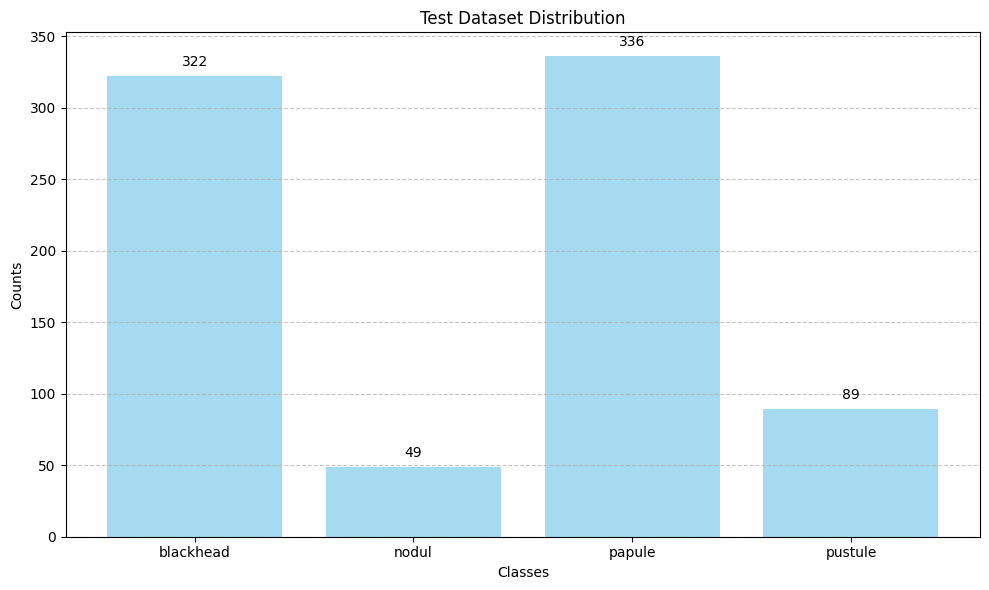

In [ ]:
plot_class_distribution(f'{base_path}/train_balanced/labels', 'Training Dataset Distribution (Balanced)')
plot_class_distribution(f'{base_path}/val_balanced/labels', 'Validation Dataset Distribution (Balanced)')
plot_class_distribution(f'{base_path}/test/labels', 'Test Dataset Distribution')

In [ ]:
model = YOLO("yolov8m.pt")

In [ ]:
results = model.train(
    data=yaml_path,
    epochs=300,
    imgsz=1024,
    batch=4,
    patience=50,
    save=True,
    device=0,
    project='acne_detection',
    name='yolov8_medical_optimal',
    exist_ok=True,
    pretrained=True,

    optimizer='AdamW',
    lr0=0.0003,
    weight_decay=0.0005,

    warmup_epochs=5,
    warmup_momentum=0.9,
    warmup_bias_lr=0.05,

    box=7.0,
    cls=1.5,
    dfl=1.0,

    degrees=5.0,
    translate=0.05,
    scale=0.10,
    shear=0.0,
    perspective=0.0,
    flipud=0.0,
    fliplr=0.5,

    hsv_h=0.005,
    hsv_s=0.20,
    hsv_v=0.15,

    mosaic=0.10,
    mixup=0.0,
    erasing=0.05,

    auto_augment='none',

    crop_fraction=1.0,

    verbose=True,
)


WARNING ⚠️ 'crop_fraction' is deprecated and will be removed in the future.
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=none, batch=4, bgr=0.0, box=7.0, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/acne_dataset/data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.0, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.05, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.005, hsv_s=0.2, hsv_v=0.15, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0003, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=0.1, multi_scale=False, name=yolov8_medical_optimal, nbs=64, nms=False, opset=None, optimize=F

In [ ]:
# Validate the model
metrics = model.val(data=yaml_path)

Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1441.0±497.4 MB/s, size: 38.5 KB)
val: Scanning /content/acne_dataset/val/labels.cache... 46 images, 0 backgrounds, 1 corrupt: 100% ━━━━━━━━━━━━ 46/46 46.7Kit/s 0.0s
val: /content/acne_dataset/val/images/acne-237_jpg.rf.e5f4f7eaa88499717b72c8d9d88fe289.jpg: ignoring corrupt image/label: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (48,) + inhomogeneous part.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 1.6s/it 4.8s
                   all         45        619      0.513      0.379      0.429      0.187
             blackhead         10        143      0.678     0.0591      0.375      0.152
                 nodul         21 

In [ ]:
# Test the model
test_metrics = model.val(data=yaml_path, split='test')

Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 26.0±28.2 MB/s, size: 42.9 KB)
val: Scanning /content/acne_dataset/test/labels... 44 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 44/44 580.5it/s 0.1s
val: New cache created: /content/acne_dataset/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 2.0s/it 6.1s
                   all         44        796      0.449      0.428      0.409      0.164
             blackhead         10        322      0.735      0.232      0.457      0.158
                 nodul         16         49      0.235      0.286      0.156     0.0618
                papule         44        336      0.395      0.673       0.54      0.236
               pustule         25         89      0.433      0.523       0.48        0.2
Speed: 33.0ms preprocess, 55.2ms inference, 0.0ms loss, 17.3ms postprocess 

In [ ]:
# Plot training results
def plot_training_results(project_path='acne_detection/yolov8_balanced'):
    """Plot training metrics from YOLOv8 results"""
    results_path = f'{project_path}/results.csv'

    if os.path.exists(results_path):
        df = pd.read_csv(results_path)
        df.columns = df.columns.str.strip()

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Box Loss
        axes[0, 0].plot(df['train/box_loss'], label='Train')
        axes[0, 0].plot(df['val/box_loss'], label='Validation')
        axes[0, 0].set_title('Box Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Class Loss
        axes[0, 1].plot(df['train/cls_loss'], label='Train')
        axes[0, 1].plot(df['val/cls_loss'], label='Validation')
        axes[0, 1].set_title('Classification Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # mAP50
        axes[1, 0].plot(df['metrics/mAP50(B)'], label='mAP50')
        axes[1, 0].set_title('mAP50')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('mAP')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # mAP50-95
        axes[1, 1].plot(df['metrics/mAP50-95(B)'], label='mAP50-95')
        axes[1, 1].set_title('mAP50-95')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('mAP')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        plt.tight_layout()
        plt.show()

plot_training_results()

In [ ]:
# Inference and visualization
def visualize_predictions(model, image_path, conf_threshold=0.25):
    """Visualize predictions on a single image"""
    results = model(image_path, conf=conf_threshold)

    for r in results:
        im_array = r.plot()
        im = Image.fromarray(im_array[..., ::-1])
        display(im)


Predictions for acne-105_jpeg.rf.e9b2ecfb4afb0217f046179f125242d2.jpg:

image 1/1 /content/acne_dataset/test/images/acne-105_jpeg.rf.e9b2ecfb4afb0217f046179f125242d2.jpg: 1024x1024 4 papules, 74.6ms
Speed: 8.8ms preprocess, 74.6ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 1024)


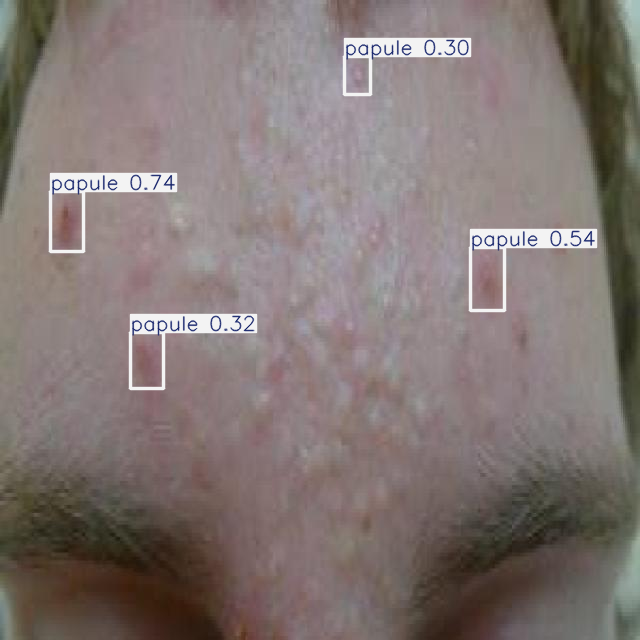


Predictions for acne-161_jpg.rf.78459635cae3ff835cac7159c10bce51.jpg:

image 1/1 /content/acne_dataset/test/images/acne-161_jpg.rf.78459635cae3ff835cac7159c10bce51.jpg: 1024x1024 2 blackheads, 6 papules, 1 pustule, 64.2ms
Speed: 8.9ms preprocess, 64.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 1024)


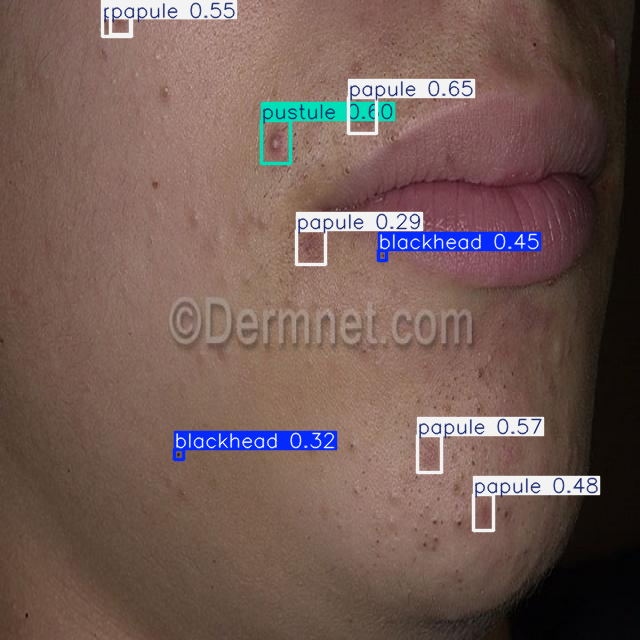


Predictions for acne-5_jpeg.rf.2d6671715f0149df7b494c4d3f12a98b.jpg:

image 1/1 /content/acne_dataset/test/images/acne-5_jpeg.rf.2d6671715f0149df7b494c4d3f12a98b.jpg: 1024x1024 1 nodul, 12 papules, 55.2ms
Speed: 9.0ms preprocess, 55.2ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 1024)


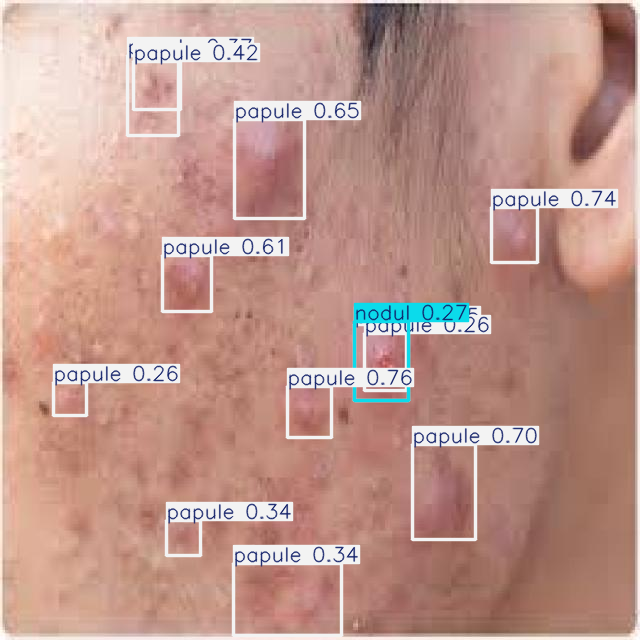


Predictions for acne-70_jpeg.rf.79a8da468a25fbeeb5a047793a3e9a4d.jpg:

image 1/1 /content/acne_dataset/test/images/acne-70_jpeg.rf.79a8da468a25fbeeb5a047793a3e9a4d.jpg: 1024x1024 1 papule, 53.3ms
Speed: 9.9ms preprocess, 53.3ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 1024)


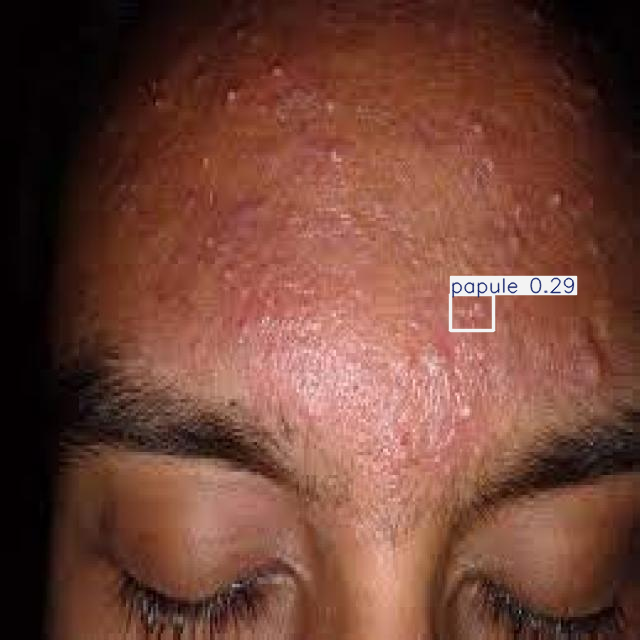

In [ ]:
test_images = os.listdir(f'{base_path}/test/images')[:4]
for img_name in test_images:
    print(f"\nPredictions for {img_name}:")
    visualize_predictions(model, f'{base_path}/test/images/{img_name}')

In [ ]:
def evaluate_yolov8_detailed(model, data_yaml_path, split='test', conf_threshold=0.25, iou_threshold=0.5):
    if split == 'train':
        labels_dir = f'{base_path}/train_balanced/labels'
    elif split == 'val':
        labels_dir = f'{base_path}/val_balanced/labels'
    else:
        labels_dir = f'{base_path}/test/labels'

    gt_counts = count_annotations(labels_dir)
    supports = [gt_counts[i] for i in range(4)] #ubah ini

    metrics = model.val(
        data=data_yaml_path,
        split=split,
        conf=conf_threshold,
        iou=iou_threshold,
        save_json=True,
        save_conf=True
    )

    print(f"\n{split.upper()} Set Performance:")
    print("-" * 70)

    headers = ['', 'precision', 'recall', 'f1-score', 'support', 'AP']
    rows = []

    total_support = sum(supports)
    weighted_p, weighted_r, weighted_f1 = 0, 0, 0

    for i in range(5):
        if i < len(metrics.box.p):
            p = metrics.box.p[i]
            r = metrics.box.r[i]
            f1 = 2 * p * r / (p + r + 1e-10)
            ap = metrics.box.ap[i] if i < len(metrics.box.ap) else 0
            support = supports[i]

            rows.append([
                class_mapping[i],
                f"{p:.2f}",
                f"{r:.2f}",
                f"{f1:.2f}",
                str(support),
                f"{ap:.2f}"
            ])

            weighted_p += p * support
            weighted_r += r * support
            weighted_f1 += f1 * support

    rows.append(['', '', '', '', '', ''])

    if hasattr(metrics, 'confusion_matrix') and metrics.confusion_matrix is not None:
        cm = metrics.confusion_matrix.matrix[:3, :3]
        correct = np.diagonal(cm).sum()
        total = cm.sum()
        accuracy = correct / total if total > 0 else 0
    else:
        accuracy = 0

    rows.append([
        'accuracy',
        '',
        '',
        f"{accuracy:.2f}",
        str(total_support),
        ''
    ])

    macro_p = metrics.box.mp
    macro_r = metrics.box.mr
    macro_f1 = 0
    for i in range(len(metrics.box.p)):
        p = metrics.box.p[i]
        r = metrics.box.r[i]
        f1 = 2 * p * r / (p + r + 1e-10)
        macro_f1 += f1
    macro_f1 /= len(metrics.box.p) if len(metrics.box.p) > 0 else 1

    rows.append([
        'macro avg',
        f"{macro_p:.2f}",
        f"{macro_r:.2f}",
        f"{macro_f1:.2f}",
        str(total_support),
        ''
    ])

    if total_support > 0:
        weighted_p /= total_support
        weighted_r /= total_support
        weighted_f1 /= total_support
    else:
        weighted_p = weighted_r = weighted_f1 = 0

    rows.append([
        'weighted avg',
        f"{weighted_p:.2f}",
        f"{weighted_r:.2f}",
        f"{weighted_f1:.2f}",
        str(total_support),
        ''
    ])

    rows.append([
        'mAP',
        '',
        '',
        '',
        '',
        f"{metrics.box.map:.2f}"
    ])

    print(tabulate(rows, headers=headers, tablefmt='simple'))

    print(f"\nGround Truth Distribution:")
    for i in range(4): #ubah ini
        print(f"  {class_mapping[i]}: {supports[i]} instances")
    print(f"  Total: {total_support} instances")

    return metrics

def plot_confusion_matrix_yolo(metrics, class_mapping, title="Confusion Matrix"):
    if hasattr(metrics, 'confusion_matrix') and metrics.confusion_matrix is not None:
        cm = metrics.confusion_matrix.matrix

        if cm.shape[0] > len(class_mapping):
            cm = cm[:len(class_mapping), :len(class_mapping)]

        plt.figure(figsize=(10, 8))

        class_names = [class_mapping[i] for i in range(len(class_mapping))]
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names,
                    cbar_kws={'label': 'Count'})

        plt.title(title, fontsize=14)
        plt.xlabel('Predicted', fontsize=12)
        plt.ylabel('True', fontsize=12)
        plt.tight_layout()
        plt.show()
    else:
        print("No confusion matrix available in metrics")

def evaluate_model_performance(model, train_dataset, test_dataset, class_mapping):
    print("Training Performance:")
    print("=" * 70)
    train_metrics = evaluate_yolov8_detailed(model, yaml_path, split='train')

    print("\n\nTraining Confusion Matrix:")
    plot_confusion_matrix_yolo(train_metrics, class_mapping, "Training Confusion Matrix")

    print("\n\nTesting Performance:")
    print("=" * 70)
    test_metrics = evaluate_yolov8_detailed(model, yaml_path, split='test')

    print("\nTesting Confusion Matrix:")
    plot_confusion_matrix_yolo(test_metrics, class_mapping, "Testing Confusion Matrix")

Evaluating model performance...
Training Performance:
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1326.8±631.6 MB/s, size: 51.0 KB)
val: Scanning /content/acne_dataset/train/labels.cache... 384 images, 6 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 384/384 715.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 24/24 1.1s/it 26.9s
                   all        384       6077       0.68      0.661       0.69      0.358
             blackhead         74        899      0.707      0.546      0.636      0.244
                 nodul        215        686      0.663      0.617      0.661      0.399
                papule        369       3746      0.699      0.786       0.77      0.419
               pustule        243        746      0.651      0.693      0.692      0.368
Speed: 7.3ms preprocess, 52.4ms inference, 0.0ms loss, 2.6ms postpro

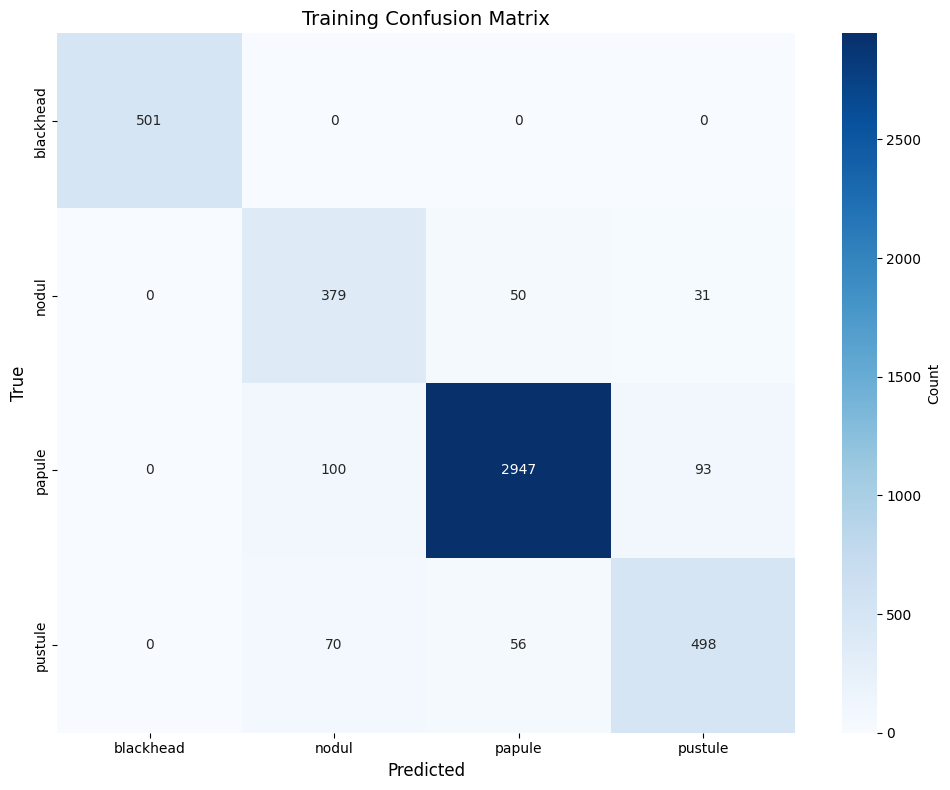



Testing Performance:
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1389.5±638.3 MB/s, size: 43.6 KB)
val: Scanning /content/acne_dataset/test/labels.cache... 44 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 44/44 60.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 2.0s/it 6.1s
                   all         44        796      0.559      0.341      0.439      0.198
             blackhead         10        322      0.844      0.168      0.506      0.209
                 nodul         16         49       0.29      0.184      0.187     0.0887
                papule         44        336      0.513      0.598      0.547      0.264
               pustule         25         89      0.587      0.416      0.518      0.232
Speed: 27.2ms preprocess, 56.9ms inference, 0.0ms loss, 4.1ms postprocess per image
Saving /content/runs/de

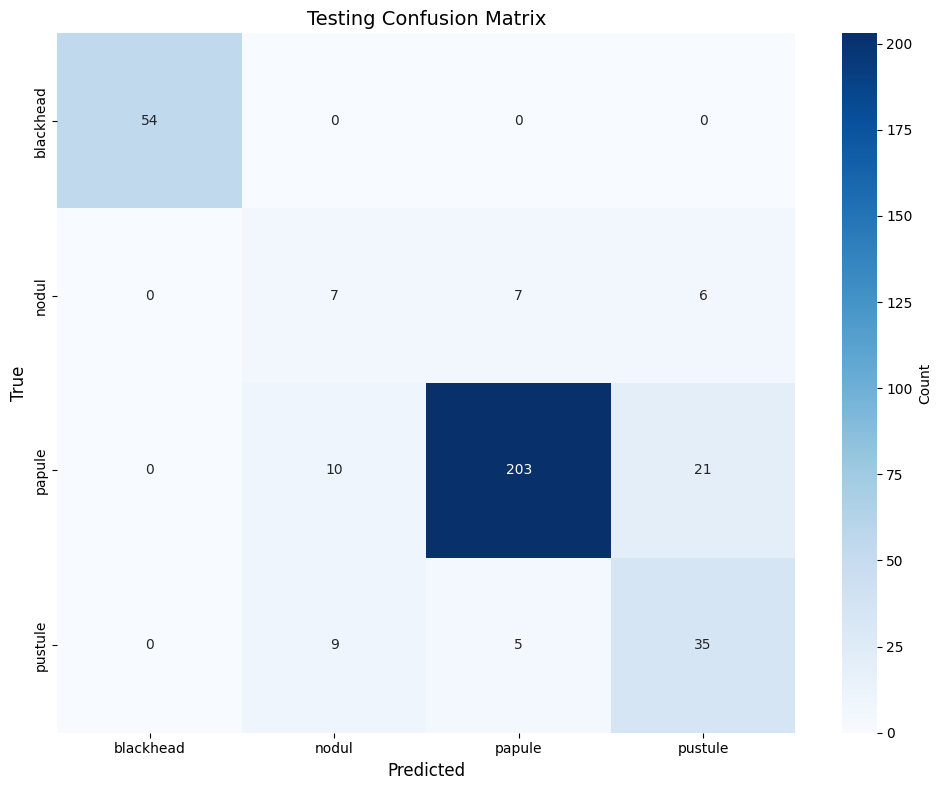

In [ ]:
print("Evaluating model performance...")
evaluate_model_performance(model, None, None, class_mapping)

In [ ]:
!zip -r acne_detection.zip /content/acne_detection

  adding: content/acne_detection/ (stored 0%)
  adding: content/acne_detection/yolov8_medical_optimal/ (stored 0%)
  adding: content/acne_detection/yolov8_medical_optimal/val_batch2_labels.jpg (deflated 6%)
  adding: content/acne_detection/yolov8_medical_optimal/val_batch0_pred.jpg (deflated 7%)
  adding: content/acne_detection/yolov8_medical_optimal/train_batch1.jpg (deflated 5%)
  adding: content/acne_detection/yolov8_medical_optimal/results.png (deflated 6%)
  adding: content/acne_detection/yolov8_medical_optimal/val_batch0_labels.jpg (deflated 6%)
  adding: content/acne_detection/yolov8_medical_optimal/BoxF1_curve.png (deflated 11%)
  adding: content/acne_detection/yolov8_medical_optimal/weights/ (stored 0%)
  adding: content/acne_detection/yolov8_medical_optimal/weights/best.pt (deflated 8%)
  adding: content/acne_detection/yolov8_medical_optimal/weights/last.pt (deflated 8%)
  adding: content/acne_detection/yolov8_medical_optimal/val_batch2_pred.jpg (deflated 6%)
  adding: conten

In [ ]:
!zip -r runs.zip /content/runs

updating: content/runs/ (stored 0%)
updating: content/runs/detect/ (stored 0%)
updating: content/runs/detect/val2/ (stored 0%)
updating: content/runs/detect/val2/val_batch2_labels.jpg (deflated 6%)
updating: content/runs/detect/val2/val_batch0_pred.jpg (deflated 2%)
updating: content/runs/detect/val2/val_batch0_labels.jpg (deflated 1%)
updating: content/runs/detect/val2/BoxF1_curve.png (deflated 11%)
updating: content/runs/detect/val2/val_batch2_pred.jpg (deflated 5%)
updating: content/runs/detect/val2/confusion_matrix_normalized.png (deflated 22%)
updating: content/runs/detect/val2/BoxP_curve.png (deflated 7%)
updating: content/runs/detect/val2/BoxR_curve.png (deflated 11%)
updating: content/runs/detect/val2/confusion_matrix.png (deflated 27%)
updating: content/runs/detect/val2/val_batch1_pred.jpg (deflated 2%)
updating: content/runs/detect/val2/val_batch1_labels.jpg (deflated 2%)
updating: content/runs/detect/val2/BoxPR_curve.png (deflated 11%)
updating: content/runs/detect/val/ (sto